# Quantum Classifier

<em> Copyright (c) 2021 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## Overview

In this tutorial, we will discuss the workflow of Variational Quantum Classifiers (VQC) and how to use quantum neural networks (QNN) to accomplish a **binary classification** task. The main representatives of this approach include the [Quantum Circuit Learning (QCL)](https://arxiv.org/abs/1803.00745) [1] by Mitarai et al. (2018), Farhi & Neven ( 2018) [2] and [Circuit-Centric Quantum Classifiers](https://arxiv.org/abs/1804.00633) [3] by Schuld et al. (2018). Here, we mainly talk about classification in the language of supervised learning. Unlike classical methods, quantum classifiers require pre-processing to encode classical data into quantum data, and then train the parameters in the quantum neural network. Finally, we benchmark the optimal classification performance through test data.

### Background

In the language of supervised learning, we need to enter a data set composed of $N$ groups of labeled data points $D = \{(x^k,y^k)\}_{k=1}^{N}$ , Where $x^k\in \mathbb{R}^{m}$ is the data point, and $y^k \in\{0,1\}$ is the label associated with the data point $x^k$. **The classification process is essentially a decision-making process, which determines the label attribution of a given data point**. For the quantum classifier framework, the realization of the classifier $\mathcal{F}$ is a combination of a quantum neural network (or parameterized quantum circuit) with parameters $\theta$, measurement, and data processing. An excellent classifier $\mathcal{F}_\theta$ should correctly map the data points in each data set to the corresponding labels as accurate as possible $\mathcal{F}_\theta(x^k ) \rightarrow y^k$. Therefore, we use the cumulative distance between the predicted label $\tilde{y}^{k} = \mathcal{F}_\theta(x^k)$ and the actual label $y^k$ as the loss function $\mathcal {L}(\theta)$ to be optimized. For binary classification tasks, we can choose the following loss function,

$$
\mathcal{L}(\theta) = \sum_{k=1}^N |\tilde{y}^{k}-y^k|^2. \tag{1}
$$

### Pipeline

Here we give the whole pipeline to implement a quantum classifier under the framework of quantum circuit learning (QCL).

1. Apply the parameterized quantum circuit $U$ on the initialized qubit $\lvert 0 \rangle$ to encode the original classical data point $x^k$ into quantum data that can be processed on a quantum computer $\lvert \psi_{in}\rangle^k$.
2. Apply the parameterized circuit $U(\theta)$ with the parameter $\theta$ on input states $\lvert \psi_{in} \rangle^k$, thereby obtaining the output state $\lvert \psi_{out} \rangle^k = U(\theta)\lvert \psi_{in} \rangle^k$.
3. Measure the quantum state $\lvert \psi_{out}\rangle^k$ processed by the quantum neural network to get the estimated label $\tilde{y}^{k}$.
4. Repeat steps 2-3 until all data points in the data set have been processed. Then calculate the loss function $\mathcal{L}(\theta)$.
5. Continuously adjust the parameter $\theta$ through optimization methods such as gradient descent to minimize the loss function. Record the optimal parameters after optimization $\theta^* $, and then we obtain the optimal classifier $\mathcal{F}_{\theta^*}$.

![QCL](figures/qclassifier-fig-pipeline.png "Figure 1: Flow chart of quantum classifier training")
<div style="text-align:center">Figure 1: Flow chart of quantum classifier training </div>

## Paddle Quantum Implementation

Here, we first import the required packages:

In [1]:
import time
import matplotlib
import numpy as np
from numpy import pi as PI
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'svg'

from paddle import fluid
from paddle.fluid.framework import ComplexVariable
from paddle.complex import matmul, transpose
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.utils import pauli_str_to_matrix

In [2]:
# These are the main functions that will be used in the tutorial
__all__ = [
    "circle_data_point_generator",
    "data_point_plot",
    "heatmap_plot",
    "myRy",
    "myRz",
    "Observable",
    "U_theta",
    "Net",
    "QClassifier",
    "main",
]

### Data set generation

One of the key parts in supervised learning is what data set to use? In this tutorial, we follow the exact approach introduced in QCL paper to generate a simple binary data set $\{(x^{(i)}, y^{(i)})\}$ with circular decision boundary, where the data point $x^{(i)}\in \mathbb{R}^{2}$, and the label $y^{(i)} \in \{0,1\}$. The figure below provides us a concrete example.

![QC-fig-data](./figures/qclassifier-fig-data.png "Figure 2: Generated data set and the corresponding decision boundary")
<div style="text-align:center">Figure 2: Generated data set and the corresponding decision boundary </div>

For the generation method and visualization, please see the following code:

In [3]:
# Generate a binary classification data set with circular decision boundary
def circle_data_point_generator(Ntrain, Ntest, boundary_gap, seed_data):
    """
    :param Ntrain: number of training samples
    :param Ntest: number of test samples
    :param boundary_gap: value in (0, 0.5), means the gap between two labels
    :param seed_data: random seed
    :return: 'Ntrain' samples for training and
             'Ntest' samples for testing
    """
    train_x, train_y = [], []
    num_samples, seed_para = 0, 0
    while num_samples <Ntrain + Ntest:
        np.random.seed((seed_data + 10) * 1000 + seed_para + num_samples)
        data_point = np.random.rand(2) * 2-1

        # If the modulus of the data point is less than (0.7 - gap), mark it as 0
        if np.linalg.norm(data_point) < 0.7-boundary_gap / 2:
            train_x.append(data_point)
            train_y.append(0.)
            num_samples += 1

        # If the modulus of the data point is greater than (0.7 + gap), mark it as 1
        elif np.linalg.norm(data_point) > 0.7 + boundary_gap / 2:
            train_x.append(data_point)
            train_y.append(1.)
            num_samples += 1
        else:
            seed_para += 1

    train_x = np.array(train_x).astype("float64")
    train_y = np.array([train_y]).astype("float64").T

    print("The dimensions of the training set x {} and y {}".format(np.shape(train_x[0:Ntrain]), np.shape(train_y[0:Ntrain])))
    print("The dimensions of the test set x {} and y {}".format(np.shape(train_x[Ntrain:]), np.shape(train_y[Ntrain:])), "\n")

    return train_x[0:Ntrain], train_y[0:Ntrain], train_x[Ntrain:], train_y[Ntrain:]


# Visualize the generated data set
def data_point_plot(data, label):
    """
    :param data: shape [M, 2], means M 2-D data points
    :param label: value 0 or 1
    :return: plot these data points
    """
    dim_samples, dim_useless = np.shape(data)
    plt.figure(1)
    for i in range(dim_samples):
        if label[i] == 0:
            plt.plot(data[i][0], data[i][1], color="r", marker="o")
        elif label[i] == 1:
            plt.plot(data[i][0], data[i][1], color="b", marker="o")
    plt.show()

The dimensions of the training set x (200, 2) and y (200, 1)
The dimensions of the test set x (100, 2) and y (100, 1) 

Visualization of 200 data points in the training set: 


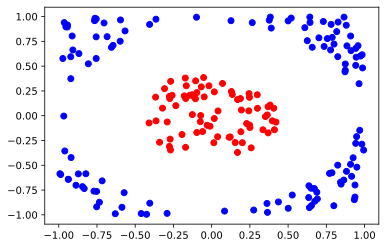

Visualization of 100 data points in the test set: 


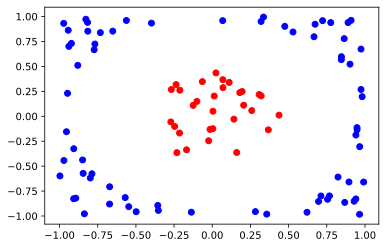


 You may wish to adjust the parameter settings to generate your own data set!


In [4]:
# Set parameters
Ntrain=200       # Specify the training set size
Ntest=100        # Specify the test set size
boundary_gap=0.5 # Set the width of the decision boundary
seed_data=2      # Fixed random seed

# Generate data set
train_x, train_y, test_x, test_y = circle_data_point_generator(
        Ntrain, Ntest, boundary_gap, seed_data)
print("Visualization of {} data points in the training set: ".format(Ntrain))
data_point_plot(train_x, train_y)
print("Visualization of {} data points in the test set: ".format(Ntest))
data_point_plot(test_x, test_y)
print("\n You may wish to adjust the parameter settings to generate your own data set!")

### Data preprocessing
Different from classical machine learning, quantum classifiers need to consider data preprocessing heavily. We need one more step to convert classical data into quantum information before running on a quantum computer. Now let's take a look at how it can be done. First, we determine the number of qubits that need to be used. Because our data $\{x^{(i)} = (x^{(i)}_0, x^{(i)}_1)\}$ is two-dimensional, according to the paper by Mitarai (2018) we need at least 2 qubits for encoding. Then prepare a group of initial quantum states $|00\rangle$. Encode the classical information $\{x^{(i)}\}$ into a group of quantum gates $U(x^{(i)})$ and act them on the initial quantum states. Finally we get a group of quantum states $|\psi^{(i)}\rangle = U(x^{(i)})|00\rangle$. In this way, we have completed the encoding from classical information into quantum information! Given $m$ qubits to encode a two-dimensional classical data point, the quantum gate is:

$$
U(x^{(i)}) = \otimes_{j=0}^{m-1} R_j^z\big[\arccos(x^{(i)}_{j \, \text{mod} \, 2}\cdot x^{(i)}_{j \, \text{mod} \, 2})\big] R_j^y\big[\arcsin(x^{(i)}_{j \, \text{mod} \, 2}) \big],
\tag{2}
$$

**Note:** In this representation, we count the first qubit as $j = 0$. For more encoding methods, see [Robust data encodings for quantum classifiers](https://arxiv.org/pdf/2003.01695.pdf). Here we also encourage readers to try new encoding methods by themselves!

Since this encoding method looks quite complicated, we might as well give a simple example. Suppose we are given a data point $x = (x_0, x_1)= (1,0)$. The label of this data point should be 1, corresponding to the **blue** point in the figure above. At the same time, the 2-qubit quantum gate $U(x)$ corresponding to the data point is,

$$
U(x) =
\bigg( R_0^z\big[\arccos(x_{0}\cdot x_{0})\big] R_0^y\big[\arcsin(x_{0}) \big] \bigg)
\otimes
\bigg( R_1^z\big[\arccos(x_{1}\cdot x_{1})\big] R_1^y\big[\arcsin(x_{1}) \big] \bigg),
\tag{3}
$$

Substituting in specific values, we get:

$$
U(x) =
\bigg( R_0^z\big[0\big] R_0^y\big[\pi/2 \big] \bigg)
\otimes
\bigg( R_1^z\big[\pi/2\big] R_1^y\big[0 \big] \bigg),
\tag{4}
$$

Recall the matrix form of rotation gates:

$$
R_x(\theta) :=
\begin{bmatrix}
\cos \frac{\theta}{2} &-i\sin \frac{\theta}{2} \\
-i\sin \frac{\theta}{2} &\cos \frac{\theta}{2}
\end{bmatrix}
,\quad
R_y(\theta) :=
\begin{bmatrix}
\cos \frac{\theta}{2} &-\sin \frac{\theta}{2} \\
\sin \frac{\theta}{2} &\cos \frac{\theta}{2}
\end{bmatrix}
,\quad
R_z(\theta) :=
\begin{bmatrix}
e^{-i\frac{\theta}{2}} & 0 \\
0 & e^{i\frac{\theta}{2}}
\end{bmatrix}.
\tag{5}
$$

Then the matrix form of the two-qubit quantum gate $U(x)$ can be written as

$$
U(x) = 
\bigg(
\begin{bmatrix}
1 & 0 \\ 
0 & 1
\end{bmatrix}
\begin{bmatrix}
\cos \frac{\pi}{4} &-\sin \frac{\pi}{4} \\ 
\sin \frac{\pi}{4} &\cos \frac{\pi}{4} 
\end{bmatrix}
\bigg)
\otimes 
\bigg(
\begin{bmatrix}
e^{-i\frac{\pi}{4}} & 0 \\ 
0 & e^{i\frac{\pi}{4}}
\end{bmatrix}
\begin{bmatrix}
1 &0 \\ 
0 &1
\end{bmatrix}
\bigg),
\tag{6}
$$

After simplification, we can get the encoded quantum state $|\psi\rangle$ by acting the quantum gate on the initialized quantum state $|00\rangle$,

$$
|\psi\rangle =
U(x)|00\rangle = \frac{1}{2}
\begin{bmatrix}
1-i &0 &-1+i &0 \\
0 &1+i &0 &-1-i \\
1-i &0 &1-i &0 \\
0 &1+i &0 &1+i
\end{bmatrix}
\begin{bmatrix}
1 \\
0 \\
0 \\
0
\end{bmatrix}
= \frac{1}{2}
\begin{bmatrix}
1-i \\
0 \\
1-i \\
0
\end{bmatrix}.
\tag{7}
$$

Then let us take a look at how to implement this encoding method in Paddle Quantum. Note that in the code, we use the following trick: 

$$
(U_1 |0\rangle)\otimes (U_2 |0\rangle) = (U_1 \otimes U_2) |0\rangle\otimes|0\rangle
= (U_1 \otimes U_2) |00\rangle.
\tag{8}
$$

In [5]:
def myRy(theta):
    """
    :param theta: parameter
    :return: Y rotation matrix
    """
    return np.array([[np.cos(theta/2), -np.sin(theta/2)],
                     [np.sin(theta/2), np.cos(theta/2)]])

def myRz(theta):
    """
    :param theta: parameter
    :return: Z rotation matrix
    """
    return np.array([[np.cos(theta/2)-np.sin(theta/2) * 1j, 0],
                     [0, np.cos(theta/2) + np.sin(theta/2) * 1j]])

# Classical -> Quantum Data Encoder
def datapoints_transform_to_state(data, n_qubits):
    """
    :param data: shape [-1, 2]
    :param n_qubits: the number of qubits to which
    the data transformed
    :return: shape [-1, 1, 2 ^ n_qubits]
    """
    dim1, dim2 = data.shape
    res = []
    for sam in range(dim1):
        res_state = 1.
        zero_state = np.array([[1, 0]])
        for i in range(n_qubits):
            if i % 2 == 0:
                state_tmp=np.dot(zero_state, myRy(np.arcsin(data[sam][0])).T)
                state_tmp=np.dot(state_tmp, myRz(np.arccos(data[sam][0] ** 2)).T)
                res_state=np.kron(res_state, state_tmp)
            elif i% 2 == 1:
                state_tmp=np.dot(zero_state, myRy(np.arcsin(data[sam][1])).T)
                state_tmp=np.dot(state_tmp, myRz(np.arccos(data[sam][1] ** 2)).T)
                res_state=np.kron(res_state, state_tmp)
        res.append(res_state)

    res = np.array(res)
    return res.astype("complex128")

print("As a test, we enter the classical information:")
print("(x_0, x_1) = (1, 0)")
print("The 2-qubit quantum state output after encoding is:")
print(datapoints_transform_to_state(np.array([[1, 0]]), n_qubits=2))

As a test, we enter the classical information:
(x_0, x_1) = (1, 0)
The 2-qubit quantum state output after encoding is:
[[[0.5-0.5j 0. +0.j  0.5-0.5j 0. +0.j ]]]


### Building Quantum Neural Network 
After completing the encoding from classical data to quantum data, we can now input these quantum states into the quantum computer. Before that, we also need to design the quantum neural network.

![QC-fig-classifier_circuit](figures/qclassifier-fig-circuit.png)

For convenience, we call the parameterized quantum neural network as $U(\boldsymbol{\theta})$. $U(\boldsymbol{\theta})$ is a key component of our classifier, and it needs a certain complex structure to fit our decision boundary. Similar to traditional neural networks, the structure of a quantum neural network is not unique. The structure shown above is just one case. You could design your own structure. Let’s take the previously mentioned data point $x = (x_0, x_1)= (1,0)$ as an example. After encoding, we have obtained a quantum state $|\psi\rangle$,

$$
|\psi\rangle =
\frac{1}{2}
\begin{bmatrix}
1-i \\
0 \\
1-i \\
0
\end{bmatrix}.
\tag{9}
$$

Then we input this quantum state into our quantum neural network (QNN). That is, multiply a unitary matrix by a vector to get the processed quantum state $|\varphi\rangle$

$$
|\varphi\rangle = U(\boldsymbol{\theta})|\psi\rangle.
\tag{10}
$$

If we set all the QNN parameters to be $\theta = \pi$, then we can write down the resulting state:

$$
|\varphi\rangle =
U(\boldsymbol{\theta} =\pi)|\psi\rangle =
\begin{bmatrix}
0 &0 &-1 &0 \\
-1 &0 &0 &0 \\
0 &1 &0 &0 \\
0 &0 &0 &1
\end{bmatrix}
\cdot
\frac{1}{2}
\begin{bmatrix}
1-i \\
0 \\
1-i \\
0
\end{bmatrix}
= \frac{1}{2}
\begin{bmatrix}
-1+i \\
-1+i \\
0 \\
0
\end{bmatrix}.
\tag{11}
$$

In [6]:
# Simulation of building a quantum neural network
def U_theta(theta, n, depth):
    """
    :param theta: dim: [n, depth + 3]
    :param n: number of qubits
    :param depth: circuit depth
    :return: U_theta
    """
    # Initialize the network
    cir = UAnsatz(n)
    
    # Build a rotation layer
    for i in range(n):
        cir.rz(theta[i][0], i)
        cir.ry(theta[i][1], i)
        cir.rz(theta[i][2], i)

    # The default depth is depth = 1
    # Build the entangleed layer and Ry rotation layer
    for d in range(3, depth + 3):
        for i in range(n-1):
            cir.cnot([i, i + 1])
        cir.cnot([n-1, 0])
        for i in range(n):
            cir.ry(theta[i][d], i)

    return cir.U

### Measurement and loss function
After the initial quantum state, $|\psi\rangle$ has been processed with QNN on the quantum computer (QPU), we need to measure this new quantum state $|\varphi\rangle$ to obtain the classical information. These processed classical information can be used to calculate the loss function $\mathcal{L}(\boldsymbol{\theta})$. Finally, we use the classical computer (CPU) to continuously update the QNN parameters $\boldsymbol{\theta}$ and optimize the loss function. Here we measure the expected value of the Pauli $Z$ operator on the first qubit. Specifically,

$$
\langle Z \rangle =
\langle \varphi |Z\otimes I\cdots \otimes I| \varphi\rangle.
\tag{12}
$$

Recall that the matrix of the Pauli $Z$ operator is defined as:

$$
Z := \begin{bmatrix} 1 &0 \\ 0 &-1 \end{bmatrix}.
\tag{13}
$$

Continuing our previous 2-qubit example, the expected value we get after the measurement is

$$
\langle Z \rangle =
\langle \varphi |Z\otimes I| \varphi\rangle =
\frac{1}{2}
\begin{bmatrix}
-1-i \quad
-1-i \quad
0 \quad
0
\end{bmatrix}
\begin{bmatrix}
1 &0 &0 &0 \\
0 &1 &0 &0 \\
0 &0 &-1 &0 \\
0 &0 &0 &-1
\end{bmatrix}
\cdot
\frac{1}{2}
\begin{bmatrix}
-1+i \\
-1+i \\
0 \\
0
\end{bmatrix}
= 1. \tag{14}
$$

This measurement result seems to be our original label 1. Does this mean that we have successfully classified this data point? This is not the case because the range of $\langle Z \rangle$ is usually between $[-1,1]$. To match it to our label range $y^{(i)} \in \{0,1\}$, we need to map the upper and lower limits. The simplest mapping is 

$$
\tilde{y}^{(i)} = \frac{\langle Z \rangle}{2} + \frac{1}{2} + bias \quad \in [0, 1].
\tag{15}
$$

Using bias is a trick in machine learning. The purpose is to make the decision boundary not restricted by the origin or some hyperplane. Generally, the default bias is initialized to be 0, and the optimizer will continuously update it like all the other parameters $\theta$ in the iterative process to ensure $\tilde{y}^{k} \in [0, 1]$. Of course, you can also choose other complex mappings (activation functions), such as the sigmoid function. After mapping, we can regard $\tilde{y}^{k}$ as the label we estimated. $\tilde{y}^{k}< 0.5$ corresponds to label 0, and $\tilde{y}^{k}> 0.5$ corresponds to label 1. It's time to quickly review the whole process before we finish discussion,

$$
x^{(i)} \rightarrow |\psi\rangle^{(i)} \rightarrow U(\boldsymbol{\theta})|\psi\rangle^{(i)} \rightarrow
|\varphi\rangle^{(i)} \rightarrow ^{(i)}\langle \varphi |Z\otimes I\cdots \otimes I| \varphi\rangle^{(i)}
\rightarrow \langle Z \rangle  \rightarrow \tilde{y}^{(i)}. \tag{16}
$$

Finally, we can define the loss function as a square loss function:

$$
\mathcal{L} = \sum_{(i)} |y^{(i)}-\tilde{y}^{(i)}|^2. \tag{17}
$$



In [7]:
# Generate Pauli Z operator that only acts on the first qubit
# Act the identity matrix on rest of the qubits
def Observable(n):
    """
    :param n: number of qubits
    :return: local observable: Z \otimes I \otimes ...\otimes I
    """
    Ob = pauli_str_to_matrix([[1.0,'z0']], n)
    return Ob

In [8]:
# Build the computational graph
class Net(fluid.dygraph.Layer):
    """
    Construct the model net
    """
    def __init__(self,
                 n, # number of qubits
                 depth, # circuit depth
                 seed_paras=1,
                 dtype='float64'):
        super(Net, self).__init__()

        self.n = n
        self.depth = depth
        
        # Initialize the parameters theta with a uniform distribution of [0, 2*pi]
        self.theta = self.create_parameter(
            shape=[n, depth + 3],
            attr=fluid.initializer.Uniform(low=0.0, high=2*PI, seed=seed_paras),
            dtype=dtype,
            is_bias=False)
        
        # Initialize bias
        self.bias = self.create_parameter(
            shape=[1],
            attr=fluid.initializer.NormalInitializer(scale=0.01, seed=seed_paras + 10),
            dtype=dtype,
            is_bias=False)

    # Define forward propagation mechanism, and then calculate loss function and cross-validation accuracy
    def forward(self, state_in, label):
        """
        Args:
            state_in: The input quantum state, shape [-1, 1, 2^n]
            label: label for the input state, shape [-1, 1]
        Returns:
            The loss:
                L = ((<Z> + 1)/2 + bias-label)^2
        """
        # Convert Numpy array to variable supported in PaddlePaddle dynamic graph mode
        Ob = fluid.dygraph.to_variable(Observable(self.n))
        label_pp = fluid.dygraph.to_variable(label)

        # According to the randomly initialized parameters theta to build the quantum gate
        Utheta = U_theta(self.theta, n=self.n, depth=self.depth)
        
        # Because Utheta is achieved by learning, we compute with row vectors to speed up without affecting the training effect
        state_out = matmul(state_in, Utheta) # dimension [-1, 1, 2 ** n]
        
        # Measure the expected value of Pauli Z operator <Z>
        E_Z = matmul(matmul(state_out, Ob),transpose(ComplexVariable(state_out.real, -state_out.imag), perm=[0, 2, 1]))
        
        # Mapping <Z> to the estimated value of the label
        state_predict = E_Z.real[:, 0] * 0.5 + 0.5 + self.bias
        loss = fluid.layers.reduce_mean((state_predict -label_pp) ** 2)
        
        # Calculate the accuracy of cross-validation
        is_correct = fluid.layers.where(
        fluid.layers.abs(state_predict-label_pp)< 0.5).shape[0]
        acc = is_correct / label.shape[0]

        return loss, acc, state_predict.numpy()

### Training process

After defining all the concepts above, we might take a look at the actual training process.

In [9]:
def heatmap_plot(net, N):
    # generate data points x_y_
    Num_points = 30
    x_y_ = []
    for row_y in np.linspace(0.9, -0.9, Num_points):
        row = []
        for row_x in np.linspace(-0.9, 0.9, Num_points):
            row.append([row_x, row_y])
        x_y_.append(row)
    x_y_ = np.array(x_y_).reshape(-1, 2).astype("float64")

    # make prediction: heat_data
    input_state_test = fluid.dygraph.to_variable(
        datapoints_transform_to_state(x_y_, N))
    loss_useless, acc_useless, state_predict = net(state_in=input_state_test, label=x_y_[:, 0])
    heat_data = state_predict.reshape(Num_points, Num_points)

    # plot
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    x_label = np.linspace(-0.9, 0.9, 3)
    y_label = np.linspace(0.9, -0.9, 3)
    ax.set_xticks([0, Num_points // 2, Num_points-1])
    ax.set_xticklabels(x_label)
    ax.set_yticks([0, Num_points // 2, Num_points-1])
    ax.set_yticklabels(y_label)
    im = ax.imshow(heat_data, cmap=plt.cm.RdBu)
    plt.colorbar(im)
    plt.show()

def QClassifier(Ntrain, Ntest, gap, N, D, EPOCH, LR, BATCH, seed_paras, seed_data,):
    """
    Quantum Binary Classifier
    """
    # Initialize PaddlePaddle dynamic graph mechanism
    with fluid.dygraph.guard():
        
        # Generate data set
        train_x, train_y, test_x, test_y = circle_data_point_generator(Ntrain=Ntrain, Ntest=Ntest, boundary_gap=gap, seed_data=seed_data)
        
        # Read the dimension of the training set
        N_train = train_x.shape[0]
        
        # Define optimization graph
        net = Net(n=N, depth=D, seed_paras=seed_paras)
        
        # Generally, we use Adam optimizer to get relatively good convergence
        # Of course, it can be changed to SGD or RMSprop
        opt = fluid.optimizer.AdamOptimizer(learning_rate=LR, parameter_list=net.parameters())
        
        # Initialize the registers to store the accuracy rate and other information
        summary_iter, summary_test_acc = [], []
        
        # Optimize iteration
        for ep in range(EPOCH):
            for itr in range(N_train // BATCH):
                
                # Encode classical data into a quantum state |psi>, dimension [-1, 2 ** N]
                input_state = fluid.dygraph.to_variable(datapoints_transform_to_state(train_x[itr * BATCH:(itr + 1) * BATCH], N))
                
                # Run forward propagation to calculate loss function
                loss, train_acc, state_predict_useless \
                    = net(state_in=input_state, label=train_y[itr * BATCH:(itr + 1) * BATCH])
                if itr% 50 == 0:
                    # Calculate the correct rate on the test set test_acc
                    input_state_test = fluid.dygraph.to_variable(datapoints_transform_to_state(test_x, N))
                    loss_useless, test_acc, state_predict_useless \
                        = net(state_in=input_state_test,label=test_y)
                    print("epoch:", ep, "iter:", itr,
                          "loss: %.4f"% loss.numpy(),
                          "train acc: %.4f"% train_acc,
                          "test acc: %.4f"% test_acc)
                    
                    # Store accuracy rate and other information
                    summary_iter.append(itr + ep * N_train)
                    summary_test_acc.append(test_acc)
                    
                # Under the dynamic graph mechanism, run back propagation to minimize the loss function
                loss.backward()
                opt.minimize(loss)
                net.clear_gradients()

        # Draw the decision boundary represented by heatmap
        heatmap_plot(net, N=N)

    return summary_test_acc

The dimensions of the training set x (200, 2) and y (200, 1)
The dimensions of the test set x (100, 2) and y (100, 1) 

epoch: 0 iter: 0 loss: 0.0249 train acc: 1.0000 test acc: 0.5200
epoch: 0 iter: 50 loss: 0.1501 train acc: 1.0000 test acc: 0.7500
epoch: 0 iter: 100 loss: 0.1369 train acc: 1.0000 test acc: 1.0000
epoch: 0 iter: 150 loss: 0.0838 train acc: 1.0000 test acc: 1.0000
epoch: 1 iter: 0 loss: 0.1815 train acc: 1.0000 test acc: 1.0000
epoch: 1 iter: 50 loss: 0.1355 train acc: 1.0000 test acc: 1.0000
epoch: 1 iter: 100 loss: 0.0649 train acc: 1.0000 test acc: 1.0000
epoch: 1 iter: 150 loss: 0.0781 train acc: 1.0000 test acc: 1.0000
epoch: 2 iter: 0 loss: 0.1762 train acc: 1.0000 test acc: 1.0000
epoch: 2 iter: 50 loss: 0.1357 train acc: 1.0000 test acc: 1.0000
epoch: 2 iter: 100 loss: 0.0608 train acc: 1.0000 test acc: 1.0000
epoch: 2 iter: 150 loss: 0.0761 train acc: 1.0000 test acc: 1.0000
epoch: 3 iter: 0 loss: 0.1759 train acc: 1.0000 test acc: 1.0000
epoch: 3 iter: 50 lo

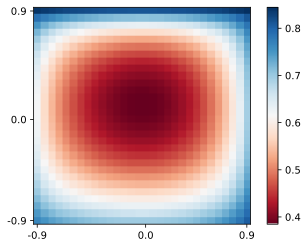

The main program finished running in  40.28910207748413 seconds.


In [10]:
def main():
    """
    main
    """
    time_start = time.time()
    acc = QClassifier(
        Ntrain = 200,    # Specify the training set size
        Ntest = 100,     # Specify the test set size
        gap = 0.5,       # Set the width of the decision boundary
        N = 4,           # Number of qubits required
        D = 1,           # Circuit depth
        EPOCH = 4,       # Number of training epochs
        LR = 0.01,       # Set the learning rate
        BATCH = 1,       # Batch size during training
        seed_paras = 19, # Set random seed to initialize various parameters
        seed_data = 2,   # Fixed random seed required to generate the data set
    )
    
    time_span = time.time()-time_start
    print('The main program finished running in ', time_span, 'seconds.')
if __name__ == '__main__':
    main()

By printing out the training results, you can see that the classification accuracy in the test set and the data set after continuous optimization has reached $100\%$.

_______

## References


[1] Mitarai, Kosuke, et al. Quantum circuit learning. [Physical Review A 98.3 (2018): 032309.](https://arxiv.org/abs/1803.00745)

[2] Farhi, Edward, and Hartmut Neven. Classification with quantum neural networks on near term processors. [arXiv preprint arXiv:1802.06002 (2018).](https://arxiv.org/abs/1802.06002)

[3] [Schuld, Maria, et al. Circuit-centric quantum classifiers. [Physical Review A 101.3 (2020): 032308.](https://arxiv.org/abs/1804.00633)
